In this example, we will take an existing vanilla model, and convert it to an equivariant model. To better exhibit the model performance, we will pick a dataset with both scalar fields and vector fields. We will use a tiny subset of the 2D computational fluid dynamics data from pdebench in the data folder. The full dataset (10,000 trajectories) can be found here: https://darus.uni-stuttgart.de/dataset.xhtml?persistentId=doi:10.18419/darus-2986.

This data consists of pressure (scalar), density (scalar), and velocity (vector) fields discretized on 128 x 128 images. The mini data set has 4 trajectories which each have 21 time steps. Our model will take as input 4 time steps and try to predict the next data set. We start by loading the data and cutting the time steps into overlapping sections of 4 input steps and 1 output step to use for training, validation, and testing.

In [ ]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
# set to -1 to prevent JAX from using the GPUs.

import matplotlib.pyplot as plt
from typing import Any, Optional, Self

import jax
import jax.numpy as jnp
import jax.random as random
from jaxtyping import ArrayLike
import equinox as eqx
import optax
import h5py

import ginjax.geometric as geom
import ginjax.ml as ml
import ginjax.models as models
import ginjax.data as gc_data

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
def read_one_h5(filename: str, num_trajectories: int) -> tuple:
    """
    Given a filename and a type of data (train, test, or validation), read the data and return as jax arrays.
    args:
        filename (str): the full file path
        data_class (str): either 'train', 'test', or 'valid'
    returns: u, vxy as jax arrays
    """
    data_dict = h5py.File(filename)

    # all of these are shape (num_trajectories, t, x, y) = (10K, 21, 128, 128)
    density = jax.device_put(
        jnp.array(data_dict["density"][:num_trajectories][()]), jax.devices("cpu")[0]
    )
    pressure = jax.device_put(
        jnp.array(data_dict["pressure"][:num_trajectories][()]), jax.devices("cpu")[0]
    )
    vx = jax.device_put(jnp.array(data_dict["Vx"][:num_trajectories][()]), jax.devices("cpu")[0])
    vy = jax.device_put(jnp.array(data_dict["Vy"][:num_trajectories][()]), jax.devices("cpu")[0])
    vxy = jnp.stack([vx, vy], axis=-1)

    data_dict.close()

    return density, pressure, vxy


def get_data(
    D: int,
    filename: str,
    n_train: int,
    n_test: int,
    past_steps: int,
    normalize: bool = True,
) -> tuple[geom.MultiImage, ...]:
    density, pressure, velocity = read_one_h5(filename, n_train + n_test)

    if normalize:
        density = (density - jnp.mean(density[:n_train])) / jnp.std(density[:n_train])
        pressure = (pressure - jnp.mean(pressure[:n_train])) / jnp.std(pressure[:n_train])
        velocity = velocity / jnp.std(velocity[:n_train])  

    is_torus = True
    train_X, train_Y = gc_data.times_series_to_multi_images(
        D,
        {(0, 0): density[:n_train], (1, 0): velocity[:n_train]},
        {},
        is_torus,
        past_steps,
        1,
    )
    train_pressure_X, train_pressure_Y = gc_data.times_series_to_multi_images(
        D,
        {(0, 0): pressure[:n_train]},
        {},
        is_torus,
        past_steps,
        1,
    )
    train_X = train_X.concat(train_pressure_X, axis=1)
    train_Y = train_Y.concat(train_pressure_Y, axis=1)

    test_X, test_Y = gc_data.times_series_to_multi_images(
        D,
        {(0, 0): density[n_train:], (1, 0): velocity[n_train:]},
        {},
        is_torus,
        past_steps,
        1,
    )
    test_pressure_X, test_pressure_Y = gc_data.times_series_to_multi_images(
        D,
        {(0, 0): pressure[n_train:]},
        {},
        is_torus,
        past_steps,
        1,
    )
    test_X = test_X.concat(test_pressure_X, axis=1)
    test_Y = test_Y.concat(test_pressure_Y, axis=1)

    return train_X, train_Y, test_X, test_Y

In [3]:
D = 2
N = 128

n_train = 3
n_test = 1
past_steps = 4  
normalize = True

train_X, train_Y, test_X, test_Y = get_data(
    D,
    '../data/mini_2D_CFD_Rand_M0.1_Eta0.01_Zeta0.01_periodic_128_Train.hdf5',
    n_train,
    n_test,
    past_steps,
    normalize,
)

print(train_X)
print(train_Y)
print(test_X)
print(test_Y)

typical_cnn_input = train_X.to_scalar_multi_image()[(0,0)]
print(f'Typical CNN shape (N,C,H,W): {typical_cnn_input.shape}')

<class 'geometricconvolutions.geometric.multi_image.MultiImage'> D: 2, is_torus: (True, True)
	(0, 0): (51, 8, 128, 128)
	(1, 0): (51, 4, 128, 128, 2)

<class 'geometricconvolutions.geometric.multi_image.MultiImage'> D: 2, is_torus: (True, True)
	(0, 0): (51, 2, 128, 128)
	(1, 0): (51, 1, 128, 128, 2)

<class 'geometricconvolutions.geometric.multi_image.MultiImage'> D: 2, is_torus: (True, True)
	(0, 0): (17, 8, 128, 128)
	(1, 0): (17, 4, 128, 128, 2)

<class 'geometricconvolutions.geometric.multi_image.MultiImage'> D: 2, is_torus: (True, True)
	(0, 0): (17, 2, 128, 128)
	(1, 0): (17, 1, 128, 128, 2)

Typical CNN shape (N,C,H,W): (51, 16, 128, 128)


We can see that the inputs have 8 scalar channels for 4 timesteps each of the density and pressure and 4 timesteps for the velocity. Likewise, the outputs have 2 scalar channels and 1 vector channel. We can convert the input data to being entirely channels of a scalar image, which would be the typical input to a vanilla CNN. This would have 16 input channels, 8 for the 8 scalar images and 8 for the 4 vector images. Now let us define a typical equinox model to do machine learning.

In [4]:
class VanillaCNN(eqx.Module):
    layers: list

    def __init__(
        self: Self, 
        in_channels: int, 
        out_channels: int, 
        width: int, 
        kernel_size: int, 
        key: ArrayLike,
    ) -> None:
        key1, key2, key3, key4, key5, key6, key7 = jax.random.split(key, 7)
        self.layers = [
            # encoder
            eqx.nn.Conv2d(in_channels, width, kernel_size, padding='SAME', padding_mode='CIRCULAR', key=key1),
            jax.nn.relu,
            eqx.nn.Conv2d(width, width, kernel_size, padding='SAME', padding_mode='CIRCULAR', key=key2),
            jax.nn.relu,
            # pooling
            eqx.nn.MaxPool2d(kernel_size=2, stride=2),
            eqx.nn.Conv2d(width, 2*width, kernel_size, padding='SAME', padding_mode='CIRCULAR', key=key3),
            jax.nn.relu,
            eqx.nn.Conv2d(2*width, 2*width, kernel_size, padding='SAME', padding_mode='CIRCULAR', key=key4),
            jax.nn.relu,
            eqx.nn.ConvTranspose2d(2*width, width, kernel_size=2, stride=2, padding='SAME', padding_mode='CIRCULAR', key=key5),
            jax.nn.relu,
            # decoder
            eqx.nn.Conv2d(width, width, kernel_size, padding='SAME', padding_mode='CIRCULAR', key=key6),
            jax.nn.relu,
            eqx.nn.Conv2d(width, out_channels, kernel_size, padding='SAME', padding_mode='CIRCULAR', key=key7),
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        for layer in self.layers:
            x = layer(x)

        return x

key = random.PRNGKey(0)
key, subkey = jax.random.split(key, 2)
vanilla_model = VanillaCNN(in_channels=16, out_channels=4, width=32, kernel_size=3, key=subkey)
print(vanilla_model)

VanillaCNN(
  layers=[
    Conv2d(
      num_spatial_dims=2,
      weight=f32[32,16,3,3],
      bias=f32[32,1,1],
      in_channels=16,
      out_channels=32,
      kernel_size=(3, 3),
      stride=(1, 1),
      padding='SAME',
      dilation=(1, 1),
      groups=1,
      use_bias=True,
      padding_mode='CIRCULAR'
    ),
    <wrapped function relu>,
    Conv2d(
      num_spatial_dims=2,
      weight=f32[32,32,3,3],
      bias=f32[32,1,1],
      in_channels=32,
      out_channels=32,
      kernel_size=(3, 3),
      stride=(1, 1),
      padding='SAME',
      dilation=(1, 1),
      groups=1,
      use_bias=True,
      padding_mode='CIRCULAR'
    ),
    <wrapped function relu>,
    MaxPool2d(
      init=-inf,
      operation=<function max>,
      num_spatial_dims=2,
      kernel_size=(2, 2),
      stride=(2, 2),
      padding=((0, 0), (0, 0)),
      use_ceil=False
    ),
    Conv2d(
      num_spatial_dims=2,
      weight=f32[64,32,3,3],
      bias=f32[64,1,1],
      in_channels=32,
     

To convert this model to an equivariant version, we can replace each layer with its equivariant counterpart. These layers process MultiImages, so rather than defining the number of input and output channels, we must define the number of input and output channels for each type of geometric image. We call this object the MultiImage signature, which is a tuple of pairs of key, number of channels. The key itself is again a tuple of the tensor order and parity. We can easily generate the signature of a multi image `A` by doing `A.get_signature()`. See below for the signatures.


In [5]:
print('Input signature:', train_X.get_signature())
print('Output signature:', train_Y.get_signature())


Input signature: (((0, 0), 8), ((1, 0), 4))
Output signature: (((0, 0), 2), ((1, 0), 1))


Each intermediate step of the model will also be a MultiImage, so we need to define what tensor orders and parities those will be. Additionally, we need to define the number of channels for each image type. Typically, we will let the image types by the union of input and output image types, and we will set a width which will be the same for each image type. For activation functions, we use the Vector Neuron nonlinearity from: https://arxiv.org/abs/2104.12229. There are other options for equivariant nonlinearities, but this performs the best of ones that we have tried, and it is flexible enough to adapt typical nonlinearities such as relu, gelu, etc.

The layer conversions are as follows:
* Conv -> ConvContract
* activation -> VectorNeuronNonLinear of that activation
* MaxPool -> MaxNormPool
* ConvTranspose -> ConvContract with `lhs_dilation` 

In [6]:
class EquivariantCNN(eqx.Module):
    D: int
    layers: list

    def __init__(
        self: Self, 
        D: int,
        input_keys: geom.Signature, 
        output_keys: geom.Signature, 
        width: int, 
        invariant_filters: geom.MultiImage,
        upsample_filters: geom.MultiImage,
        key: ArrayLike,
    ) -> None:
        self.D = D
        mid_keys = geom.signature_union(input_keys, output_keys, width)
        mid_keys2 = geom.signature_union(input_keys, output_keys, width*2)
        rand_keys = random.split(key, 14)
        self.layers = [
            # encoder
            ml.ConvContract(input_keys, mid_keys, invariant_filters, key=rand_keys[0]),
            ml.VectorNeuronNonlinear(mid_keys, D, jax.nn.relu, key=rand_keys[1]),
            ml.ConvContract(mid_keys, mid_keys, invariant_filters, key=rand_keys[2]),
            ml.VectorNeuronNonlinear(mid_keys, D, jax.nn.relu, key=rand_keys[3]),
            # pooling
            ml.MaxNormPool(patch_len=2),
            ml.ConvContract(mid_keys, mid_keys2, invariant_filters, key=rand_keys[4]),
            ml.VectorNeuronNonlinear(mid_keys2, D, jax.nn.relu, key=rand_keys[5]),
            ml.ConvContract(mid_keys2, mid_keys2, invariant_filters, key=rand_keys[6]),
            ml.VectorNeuronNonlinear(mid_keys2, D, jax.nn.relu, key=rand_keys[7]),
            ml.ConvContract(
                mid_keys2, 
                mid_keys, 
                upsample_filters, 
                padding=((1, 1),) * self.D, 
                lhs_dilation=(2,) * self.D,
                key=rand_keys[8],
            ),
            ml.VectorNeuronNonlinear(mid_keys, D, jax.nn.relu, key=rand_keys[9]),
            # decoder
            ml.ConvContract(mid_keys, mid_keys, invariant_filters, key=rand_keys[10]),
            ml.VectorNeuronNonlinear(mid_keys, D, jax.nn.relu, key=rand_keys[11]),
            ml.ConvContract(mid_keys, output_keys, invariant_filters, key=rand_keys[12]),
        ]

    def __call__(
        self: Self, 
        x: geom.MultiImage, 
        aux_data: Optional[eqx.nn.State] = None,
    ) -> tuple[geom.MultiImage, Optional[eqx.nn.State]]:
        for layer in self.layers:
            x = layer(x)

        return x, aux_data
    
operators = geom.make_all_operators(D)
conv_filters = geom.get_invariant_filters([3], [0,1,2], [0,1], D, operators)
upsample_filters = geom.get_invariant_filters([2], [0,1,2], [0,1], D, operators)

key, subkey = random.split(key)
equiv_model = EquivariantCNN(D, train_X.get_signature(), train_Y.get_signature(), 32, conv_filters, upsample_filters, key=subkey)
print(equiv_model)

EquivariantCNN(
  D=2,
  layers=[
    ConvContract(
      weights={
        (0, 0):
        {(1, 0): f32[32,8,2], (0, 0): f32[32,8,3]},
        (1, 0):
        {(1, 0): f32[32,4,5], (0, 0): f32[32,4,2]}
      },
      bias={(1, 0): f32[32,1,1,1], (0, 0): f32[32,1,1]},
      invariant_filters=<geometricconvolutions.geometric.multi_image.MultiImage object at 0x7f2d886c6030>,
      input_keys=(((0, 0), 8), ((1, 0), 4)),
      target_keys=(((1, 0), 32), ((0, 0), 32)),
      use_bias='auto',
      stride=1,
      padding=None,
      lhs_dilation=None,
      rhs_dilation=1,
      D=2,
      fast_mode=False,
      missing_filter=False
    ),
    VectorNeuronNonlinear(
      weights={(1, 0): f32[32,32]},
      eps=1e-05,
      D=2,
      scalar_activation=<wrapped function relu>
    ),
    ConvContract(
      weights={
        (1, 0):
        {(1, 0): f32[32,32,5], (0, 0): f32[32,32,2]},
        (0, 0):
        {(1, 0): f32[32,32,2], (0, 0): f32[32,32,3]}
      },
      bias={(1, 0): f32[32,1,

We can now proceed with our typical training pipeline. We define our `map_and_loss` function with the `timestep_smse_loss`. To conform with our train function, the map_and_loss takes 4 arguments: the model, the input multi image, the output target multi image, and aux data that would be used by layers like BatchNorm. Likewise, it returns the loss and the aux data.

In [7]:
def map_and_loss(
    model: models.MultiImageModule,
    multi_image_x: geom.MultiImage,
    multi_image_y: geom.MultiImage,
    aux_data: Optional[eqx.nn.State] = None,
) -> tuple[jax.Array, Optional[eqx.nn.State]]:
    pred_y, aux_data = jax.vmap(model, in_axes=(0,None), out_axes=(0,None))(multi_image_x, aux_data)
    return ml.timestep_smse_loss(pred_y, multi_image_y, n_steps=1)[0], aux_data

Since our training loop works with MultiImage inputs, we would like our vanilla model to also work with MultiImages. We can use the ModelWrapper class to wrap any model that handles image-like data.

In [8]:
vanilla_multi_image_model = models.ModelWrapper(D, vanilla_model, train_Y.get_signature(), train_Y.is_torus)

In [9]:
models.count_params(equiv_model)
models.count_params(vanilla_multi_image_model)


87940

Finally, we specify our training hyper-parameters and call our training loop. The epochs, batch size, learning rate, and optimizer could likely be further tuned, but the choices below are sufficient for this simple problem.

In [10]:
# training_params
epochs = 50
batch_size = 5

model_list = [
    ('Equivariant Model', equiv_model, 1e-3),
    ('Vanilla Model', vanilla_multi_image_model, 1e-3), 
]

trained_models = []
for model_name, model, lr in model_list:
    print(f'{model_name} ({models.count_params(model)}), {lr}')
    key, subkey = random.split(key)
    trained_model, _, train_loss, val_loss = ml.train(
        train_X, 
        train_Y, 
        map_and_loss, 
        model, 
        subkey, 
        ml.EpochStop(epochs, verbose=1), 
        batch_size, 
        optax.adamw(lr),
    )

    key, subkey = random.split(key)
    print('train_loss:', train_loss)
    print('val_loss:', val_loss)
    trained_models.append((model_name, trained_model))


Equivariant Model (126905), 0.001
Epoch 5 Train: 0.4281670 Epoch time: 1.81309
Epoch 10 Train: 0.3123351 Epoch time: 1.88709
Epoch 15 Train: 0.2677635 Epoch time: 1.82430
Epoch 20 Train: 0.2242009 Epoch time: 1.92159
Epoch 25 Train: 0.2112530 Epoch time: 1.83373
Epoch 30 Train: 0.2379112 Epoch time: 2.22728
Epoch 35 Train: 0.1878465 Epoch time: 1.84313
Epoch 40 Train: 0.1679185 Epoch time: 1.83658
Epoch 45 Train: 0.1401320 Epoch time: 1.88376
Epoch 50 Train: 0.1284394 Epoch time: 1.79857
train_loss: 0.12843941
val_loss: None
Vanilla Model (87940), 0.001
Epoch 5 Train: 0.8677534 Epoch time: 0.35027
Epoch 10 Train: 0.8418769 Epoch time: 0.35908
Epoch 15 Train: 0.6893798 Epoch time: 0.32163
Epoch 20 Train: 0.6873947 Epoch time: 0.34052
Epoch 25 Train: 0.7894832 Epoch time: 0.37095
Epoch 30 Train: 0.6513161 Epoch time: 0.34593
Epoch 35 Train: 0.5923902 Epoch time: 0.34212
Epoch 40 Train: 0.5446648 Epoch time: 0.34225
Epoch 45 Train: 0.5001429 Epoch time: 0.34630
Epoch 50 Train: 0.4754890 E

We can see that the loss of the equivariant model is smaller than the vanilla model. Now lets see how the model performs on one example from the training set.

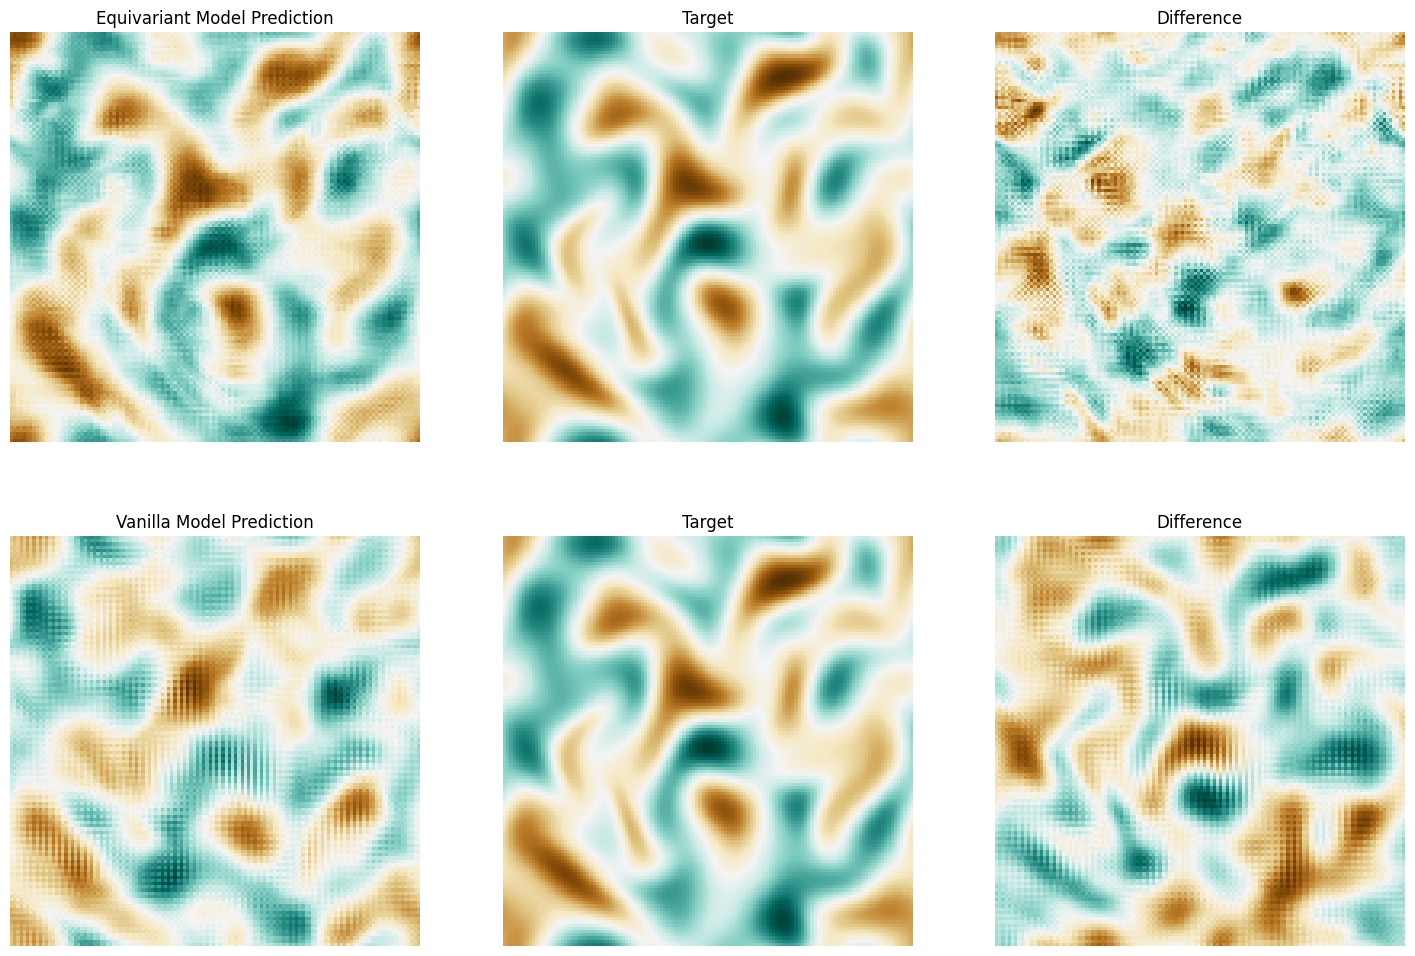

In [11]:
img_idx = 0 # 0 for density, 1 for pressure, 2 for velocity

fig, axes = plt.subplots(nrows=len(trained_models), ncols=3, figsize=(6 * 3, 6 * len(trained_models)))
for i, (model_name, trained_model) in enumerate(trained_models):
    vmap_trained_model = jax.vmap(trained_model, in_axes=(0,None), out_axes=(0,None))
    pred_y = vmap_trained_model(train_X.get_one(), None)[0].to_images()[img_idx]
    y_img = train_Y.get_one().to_images()[img_idx]

    pred_y.plot(axes[i,0], f'{model_name} Prediction')
    y_img.plot(axes[i,1], 'Target')
    (pred_y - y_img).plot(axes[i,2], 'Difference')


Since our training data set is so small, the predictions don't look great, but hopefully this gives you an idea of the problem. Finally, we would like to know how the model performs on a test data set. We print the average test error, as well as one example.

Equivariant Model test_loss: 0.6452899
Vanilla Model test_loss: 6.5092845


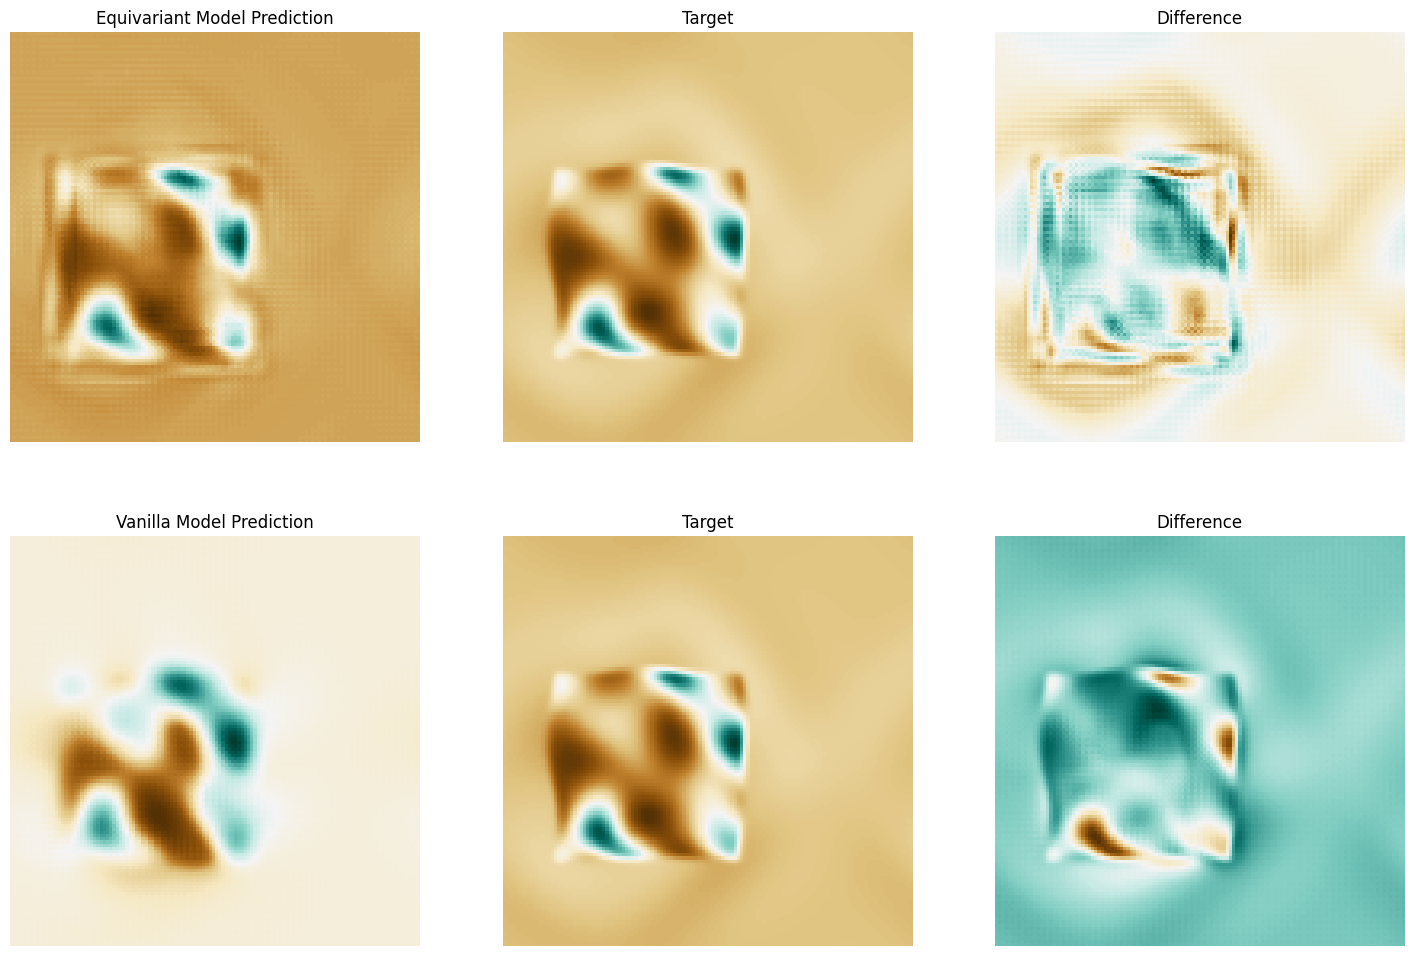

In [12]:
img_idx = 0 # 0 for density, 1 for pressure, 2 for velocity

fig, axes = plt.subplots(nrows=len(trained_models), ncols=3, figsize=(6 * 3, 6 * len(trained_models)))
for i, (model_name, trained_model) in enumerate(trained_models):
    test_loss = ml.map_loss_in_batches(map_and_loss, trained_model, test_X, test_Y, batch_size, None)
    print(f'{model_name} test_loss:', test_loss)

    vmap_trained_model = jax.vmap(trained_model, in_axes=(0,None), out_axes=(0,None))
    pred_y  = jax.vmap(trained_model)(test_X.get_one(), None)[0].to_images()[img_idx]
    y_img = test_Y.get_one().to_images()[img_idx]

    pred_y.plot(axes[i,0], f'{model_name} Prediction')
    y_img.plot(axes[i,1], 'Target')
    (pred_y - y_img).plot(axes[i,2], 'Difference')

This trajectory has very different initial conditions than some of the training trajectories, and both models do significantly worse. The equivariant model does better, but we caution against reading too much into this result since the training data sets are so small for this toy example. Hopefully this notebook gives you a good idea of how to convert your non-equivariant model to an equivariant version.